# Reproduces the Cytocipher pancreas analysis

### Environment setup

***The below was tested using python 3.8.12, with a new conda environment in a new empty folder, as shown below***

    mkdir cytocipher_test
    cd cytocipher_test
    conda create -n cytocipher_test python=3.8.12
    conda activate cytocipher_test

### Cytocipher installation

In [ ]:
!git clone https://github.com/BradBalderson/Cytocipher.git
!pip install -r Cytocipher/requirements.txt
!pip install --no-deps scanpy==1.9.1
!pip install scvelo==0.2.4

In [2]:
import scanpy as sc
import scvelo as scv

import sys
sys.path.append('Cytocipher')
import cytocipher as cc

### Downloading data & preprocessing 

Following the magnificent scvelo tutorial here:
https://scvelo.readthedocs.io/VelocityBasics/

In [3]:
data = scv.datasets.pancreas()

100%|████████████████████████████████████████████████| 50.0M/50.0M [00:01<00:00, 35.6MB/s]


Preprocessing

In [4]:
scv.pp.filter_genes(data, min_shared_counts=4)
scv.pp.normalize_per_cell(data)
scv.pp.log1p(data)

print(data.shape)

Filtered out 18138 genes that are detected 4 counts (shared).
Normalized count data: X, spliced, unspliced.
(3696, 9860)


### Reproduce scvelo velocity embedding for reference

In [ ]:
scv.pp.moments(data, n_pcs=30, n_neighbors=30)
scv.tl.velocity(data)
scv.tl.velocity_graph(data)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


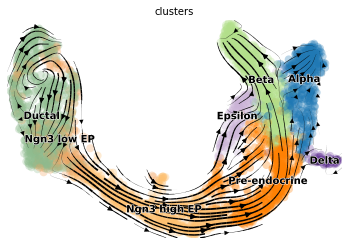

In [6]:
scv.pl.velocity_embedding_stream(data, basis='umap')

### Over-clustering

In [7]:
sc.tl.leiden(data, resolution=3.5)

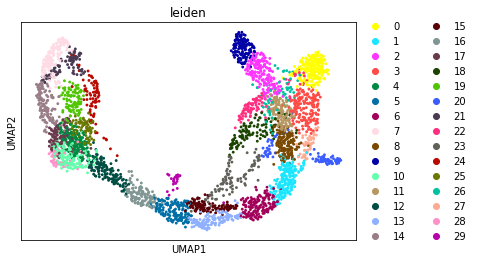

In [8]:
sc.pl.umap(data, color='leiden')

# Running Cytocipher to determine significantly different clusters

### First confirm over-clustering with code-scoring

In [9]:
### Can check documentation with:
?cc.tl.code_enrich

In [10]:
sc.pp.highly_variable_genes(data, min_disp=.2)

cc.tl.get_markers(data, 'leiden', var_groups='highly_variable', n_top=6)
cc.tl.code_enrich(data, 'leiden', n_cpus=2)

Added data.uns['leiden_markers']
Added data.obsm['leiden_enrich_scores']


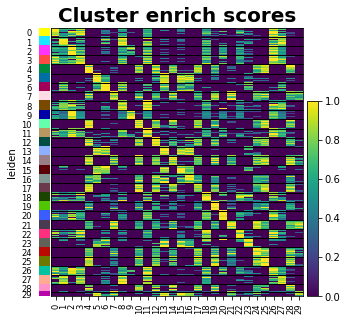

In [11]:
cc.pl.enrich_heatmap(data, 'leiden', figsize=(5,5))

## Determine significantly different clusters

In [12]:
cc.tl.merge_clusters(data, 'leiden', var_groups='highly_variable', n_cpus=2, n_top_genes=6, p_cut=.05)

Initial merge.
Added data.obs[f'leiden_merged']
Exiting due to reaching max_iter 0


In [13]:
#### Asthetic colours
data.uns['leiden_merged_colors'] = ['#f7b6d2','#d62728','#aec7e8','#9edae5','#2ca02c','#ff9896','#ffbb78',
                                    '#8c564b','#1f77b4','#c5b0d5','#bcbd22','#c7c7c7','#17becf','#e377c2']

### Visualise the merged clusters

Important to make sure the cluster merging makes sense; for instance, we should not see clusters merged that are highly distint in the UMAP space, and the cluster code scores should look distinct for each cluster.

Below, we can see cytocipher cluster merge has identified interesting intermediate states in pancreas differentiation.

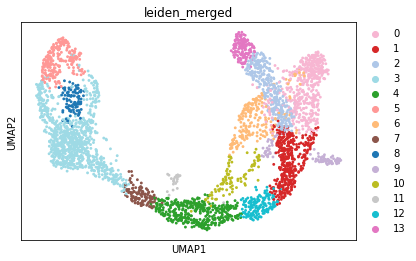

In [14]:
sc.pl.umap(data, color=f'leiden_merged')

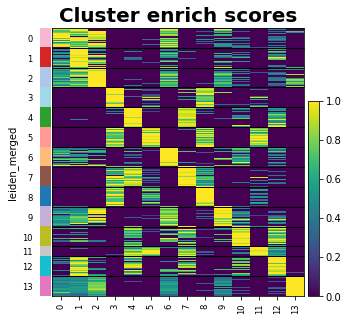

In [15]:
cc.pl.enrich_heatmap(data, 'leiden_merged', figsize=(5,5))

### Checking the p-value cutoff

We can also look at the distributions for the comparisons made when testing for cluster significant difference,
in order to determine if the threshold is too relaxed or harsh. 

Too relaxed (high p_cut), then clearly different clusters will be merged.

Too stringent (low p_cut), then clusters which are very similar may not be merged.

In the case below, the boundaries appear to create a good separation of significant vs non-significant cluster pairs. As indicated by the 'Bottom significant' having a fairly low p-value for one direction of cluster comparion (p=0.008), while the 'Bottom non-significant' has a high p-value when comparing clusters in both directions (p=0.1089 & p=0.1297).

Printing top and bottom most significant/non-significant clusters.

Top significant
p=0 (0 cells; 0 scores) vs (16 cells; 0 scores)
p=0 (0 cells; 16 scores) vs (16 cells; 16 scores)


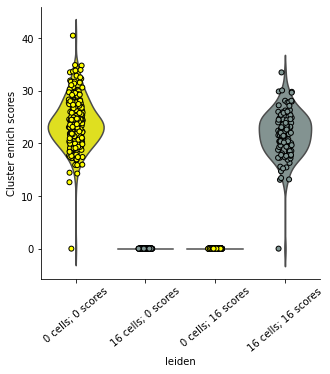

Bottom significant
p=0.9535468175771941 (16 cells; 16 scores) vs (15 cells; 16 scores)
p=0.008379962805699734 (16 cells; 15 scores) vs (15 cells; 15 scores)


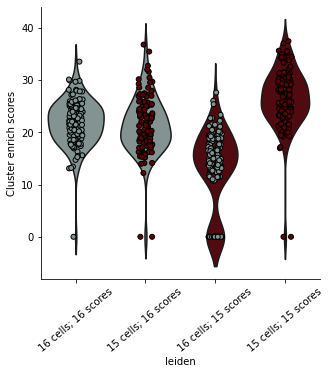

Top non-significant
p=0.8564977843816242 (4 cells; 4 scores) vs (25 cells; 4 scores)
p=0.8121513501117146 (4 cells; 25 scores) vs (25 cells; 25 scores)


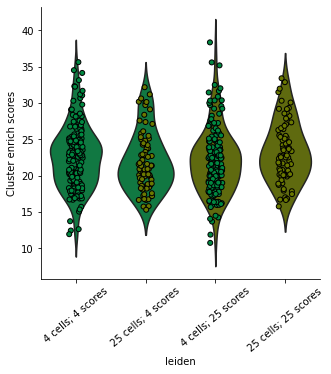

Bottom non-significnat
p=0.10898406118683482 (4 cells; 4 scores) vs (14 cells; 4 scores)
p=0.12978982347417872 (4 cells; 14 scores) vs (14 cells; 14 scores)


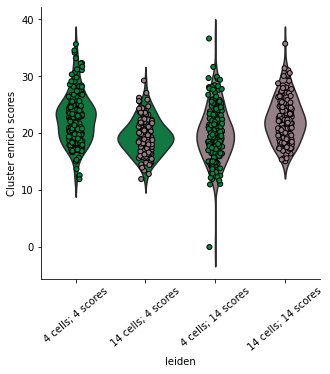

In [16]:
cc.pl.sig_cluster_diagnostics(data, 'leiden')

## Examining the expression of the top marker genes for the merged clusters

We can also look at the top marker genes for each of the merged clusters.

When visualising these & reading literature on the role of these genes in pancreas development, it's clear the new states identified correspond to important intermediate states and branch points in pancreatic cell fate determination.

In [17]:
markers = data.uns['leiden_merged_markers']
markers

{'0': array(['Cpe', 'Pcsk1n', 'Tmem27', 'Meis2', 'Tspan7', 'Aplp1'],
       dtype=object),
 '1': array(['Chgb', 'Hmgn3', 'Fev', 'Chga', 'Cpe', 'Bex2'], dtype=object),
 '2': array(['Rbp4', 'Pcsk2', '1700086L19Rik', 'Cpe', 'Pdx1', 'Rap1b'],
       dtype=object),
 '3': array(['Spp1', 'Sparc', 'Clu', 'Dbi', 'Mgst1', 'Anxa2'], dtype=object),
 '4': array(['Btbd17', 'Mdk', 'Tmsb4x', 'Neurog3', 'Gadd45a', 'Btg2'],
       dtype=object),
 '5': array(['Tuba1b', 'Hmgb2', 'Tubb5', 'H2afz', '2810417H13Rik', 'Spp1'],
       dtype=object),
 '6': array(['Isl1', 'Rbp4', 'Aplp1', 'Bex2', 'Fam183b', 'Ghrl'], dtype=object),
 '7': array(['Neurog3', 'Cd24a', 'Btbd17', 'Gadd45a', 'Mdk', 'Serpinh1'],
       dtype=object),
 '8': array(['Pebp1', 'Gapdh', 'Wfdc2', 'Spp1', 'Rpl12', 'Mgst1'], dtype=object),
 '9': array(['Rbp4', 'Isl1', 'Hmgn3', 'Hhex', 'Fam183b', 'Hadh'], dtype=object),
 '10': array(['Cdkn1a', 'Rgs17', 'Isl1', 'Krt7', 'Cck', 'Btg2'], dtype=object),
 '11': array(['Hmgb2', 'H2afv', 'Mdk', 'Tubb5', 'C

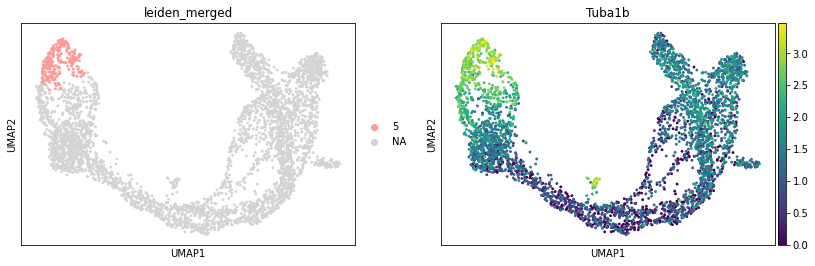

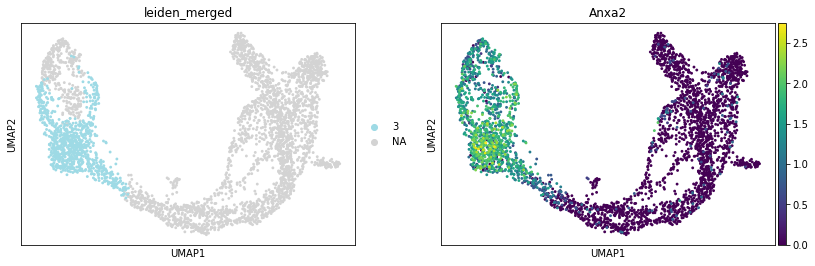

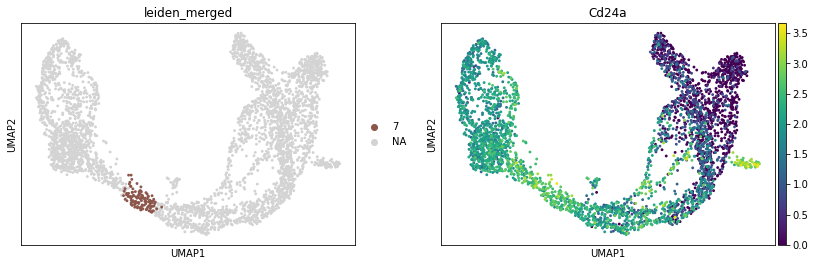

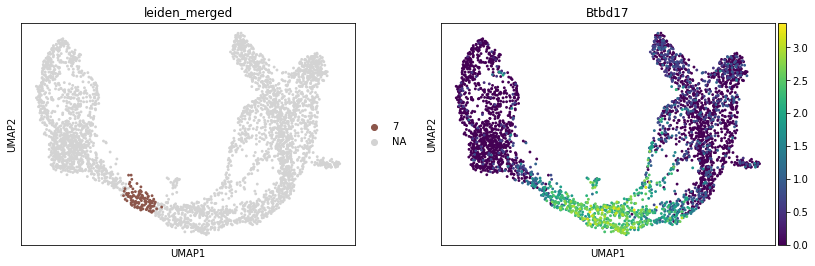

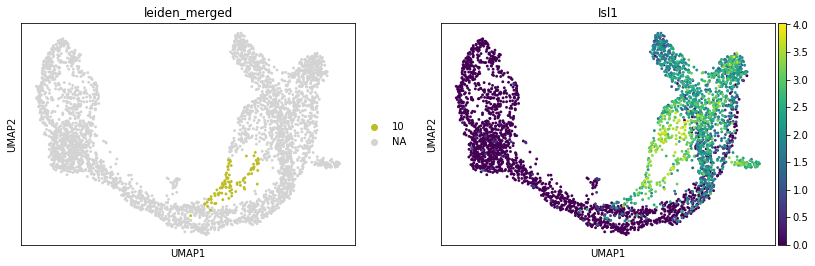

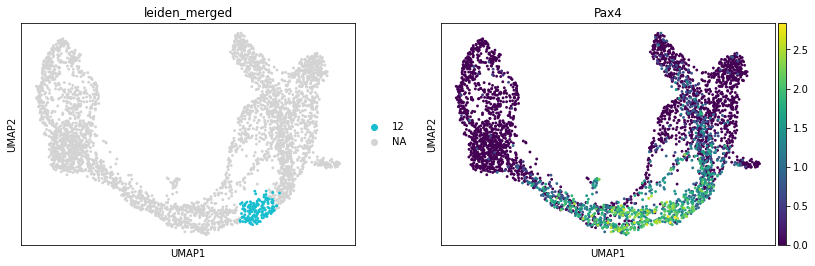

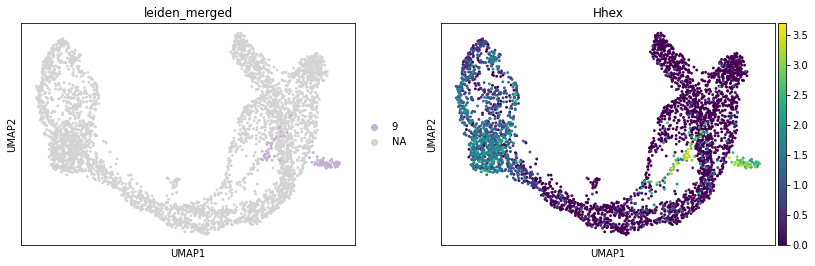

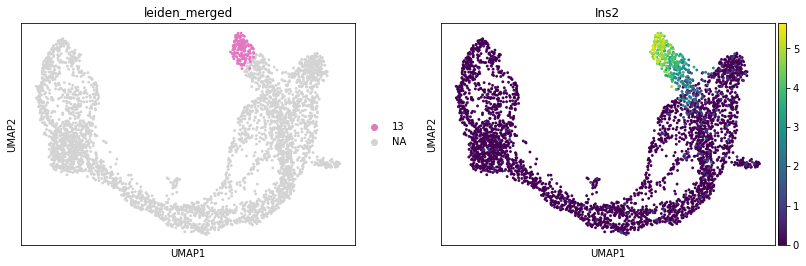

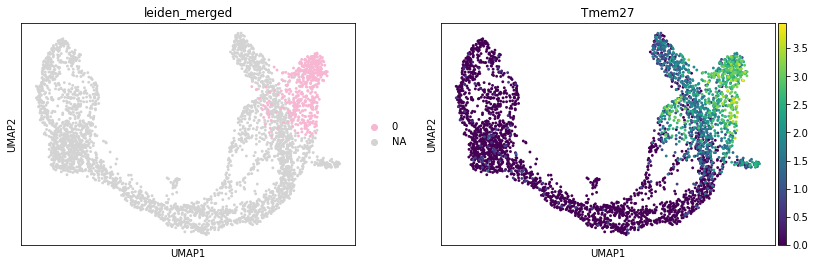

In [18]:
interesting_markers = ['Tuba1b','Anxa2','Cd24a','Btbd17','Isl1','Pax4','Hhex','Ins2','Tmem27']
clusters = ['5', '3', '7', '7', '10', '12', '9', '13', '0']
for i in range(len(clusters)):
    sc.pl.umap(data, color=['leiden_merged', interesting_markers[i]], groups=[clusters[i]])

### Thanks for taking a look, please feel free to add an issue to the github page if you find problems!

https://github.com/BradBalderson/Cytocipher